In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811634 sha256=aa622b0b3b2f10110586e7ec57713a870a4920a82dbd4e91f42c67a9f0f9d035
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd
import json
import zipfile

import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Embedding, concatenate, Flatten, Activation, Add, Dropout, Multiply, Reshape, Concatenate, Dot
from keras.optimizers import Adam
from keras import utils
from keras.callbacks import EarlyStopping

In [ ]:
with zipfile.ZipFile('data_movies.zip') as zip_ref:
    zip_ref.extractall('')

In [ ]:
def load_data(filename):
    rating_df = pd.read_json(filename)
    rating_df.columns = ['userId', 'movieId', 'rating']
    return rating_df


In [ ]:
rating_df = load_data('data_movies1.json')
rating_df

,userId,movieId,rating
0,0,3,9
1,0,5,10
2,0,8,7
3,0,10,10
4,0,13,6
...,...,...,...
12041691,21223,19764,2
12041692,21223,19873,8
12041693,21223,19878,7
12041694,21223,20750,8


In [ ]:
rating_df2 = load_data('data_movies2.json')
rating_df2

,userId,movieId,rating
0,0,1,3
1,0,11,10
2,0,20,8
3,0,30,6
4,0,36,7
...,...,...,...
3010420,21223,17960,8
3010421,21223,18777,7
3010422,21223,19061,4
3010423,21223,19780,8


In [ ]:
average_ratings = rating_df.groupby('movieId')['rating'].mean()
average_ratings

movieId
0        9.257981
1        8.141070
2        8.432739
3        8.100966
4        7.116090
           ...   
21040    6.277778
21041    6.191489
21042    6.475000
21043    7.000000
21044    6.413043
Name: rating, Length: 21045, dtype: float64

In [ ]:
rating_df2['avgRating'] = rating_df2['movieId'].map(average_ratings)
rating_df2['ratingError'] = np.abs(rating_df2['rating'] - rating_df2['avgRating'])
rating_df2

,userId,movieId,rating,avgRating,ratingError
0,0,1,3,8.141070,5.141070
1,0,11,10,8.702269,1.297731
2,0,20,8,8.257428,0.257428
3,0,30,6,8.713479,2.713479
4,0,36,7,6.873326,0.126674
...,...,...,...,...,...
3010420,21223,17960,8,6.103448,1.896552
3010421,21223,18777,7,7.117647,0.117647
3010422,21223,19061,4,4.863636,0.863636
3010423,21223,19780,8,7.586957,0.413043


In [ ]:
avg_user_rating_error = rating_df2.groupby('userId')['ratingError'].mean()
avg_user_rating_error

userId
0        1.331987
1        2.148384
2        0.899063
3        1.123085
4        0.742743
           ...   
21219    1.368214
21220    1.393690
21221    2.094601
21222    1.900252
21223    1.139338
Name: ratingError, Length: 21224, dtype: float64

In [ ]:
mean_error = avg_user_rating_error.mean()
mean_error

1.2773918838597016

In [ ]:
(np.abs(avg_user_rating_error - mean_error)).mean()

0.2691221776417952

In [ ]:
me = 15122
avg_user_rating_error[me]

1.561049305421501

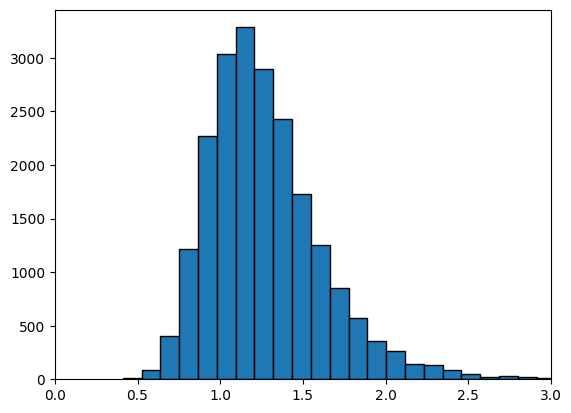

In [ ]:
plt.hist(avg_user_rating_error, bins=50, edgecolor='black')
plt.xlim(0, 3)
plt.show()

In [ ]:
# SVD part

In [ ]:
reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(rating_df[['userId', 'movieId', 'rating']], reader)

# trainset, testset = train_test_split(data, test_size=.15)
trainset = data.build_full_trainset()
testset = list(zip(rating_df2.userId.values, rating_df2.movieId.values, rating_df2.rating.values))

algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)
nn_ratings = [pred.est for pred in predictions]


In [ ]:
rating_df2['nnRating'] = nn_ratings
rating_df2['nnError'] = np.abs(rating_df2['rating'] - rating_df2['nnRating'])
rating_df2

,userId,movieId,rating,avgRating,ratingError,nnRating,nnError
0,0,1,3,8.141070,5.141070,8.130511,5.130511
1,0,11,10,8.702269,1.297731,8.706836,1.293164
2,0,20,8,8.257428,0.257428,8.235668,0.235668
3,0,30,6,8.713479,2.713479,8.578824,2.578824
4,0,36,7,6.873326,0.126674,6.855263,0.144737
...,...,...,...,...,...,...,...
3010420,21223,17960,8,6.103448,1.896552,6.330541,1.669459
3010421,21223,18777,7,7.117647,0.117647,7.700462,0.700462
3010422,21223,19061,4,4.863636,0.863636,4.881828,0.881828
3010423,21223,19780,8,7.586957,0.413043,7.873007,0.126993


In [ ]:
avg_user_rating_error2 = rating_df2.groupby('userId')['nnError'].mean()
avg_user_rating_error2

userId
0        1.555248
1        2.081609
2        0.768254
3        1.096725
4        0.704788
           ...   
21219    1.135276
21220    1.222598
21221    1.340034
21222    1.449667
21223    1.119045
Name: nnError, Length: 21224, dtype: float64

In [ ]:
mean_error2 = avg_user_rating_error2.mean()
mean_error2

1.0755835123040611

In [ ]:
(np.abs(avg_user_rating_error2 - mean_error2)).mean()

0.2214089124695658

In [ ]:
avg_user_rating_error2[me]

1.6175281898660812

In [ ]:
# svd_res save

In [ ]:
movie_ids = rating_df['movieId'].unique()
testset_my = [[me, movie_id, 4.] for movie_id in movie_ids]

predictions_my = algo.test(testset_my)
nn_ratings_my = [{'iid': int(pred.iid), 'est': pred.est} for pred in predictions_my]
nn_ratings_my = sorted(nn_ratings_my, key=lambda x: x['iid'])

In [ ]:
with open('svd_res.json', 'w') as f:
    json.dump(nn_ratings_my, f, indent=4)

In [ ]:
# NN part

In [ ]:
train_user_ids = rating_df['userId'].values
train_movie_ids = rating_df['movieId'].values
train_ratings = rating_df['rating'].values

val_user_ids = rating_df2['userId'].values
val_movie_ids = rating_df2['movieId'].values
val_ratings = rating_df2['rating'].values

In [ ]:
num_users = max(train_user_ids.max(), val_user_ids.max())  + 1
print(num_users)
num_movies = max(train_movie_ids.max(), val_movie_ids.max())  + 1
print(num_movies)

embedding_size = 64

def get_ncf_model1():
    user_inp = Input((1,))
    user_hidden = Embedding(input_dim=num_users, output_dim=embedding_size)(user_inp)
    user_hidden = Flatten()(user_hidden)

    item_inp = Input((1,))
    item_hidden = Embedding(input_dim=num_movies, output_dim=embedding_size)(item_inp)
    item_hidden = Flatten()(item_hidden)

    mf_output = Multiply()([user_hidden, item_hidden])

    hidden = concatenate([user_hidden, item_hidden])
    hidden = Dense(2048, activation='relu')(hidden)
    mlp_output = Dense(64, activation='relu')(hidden)

    output = concatenate([mf_output, mlp_output])
    output = Dense(1, activation='linear')(output)

    model = Model(inputs=[user_inp, item_inp], outputs=output)
    model.compile(loss='mae', optimizer='adam')
    return model

def get_ncf_model2():
    user_inp = Input((1,))
    user_hidden = Embedding(input_dim=num_users, output_dim=embedding_size, name="user_embed")(user_inp)
    user_hidden = Flatten()(user_hidden)

    item_inp = Input((1,))
    item_hidden = Embedding(input_dim=num_movies, output_dim=embedding_size, name="movie_embed")(item_inp)
    item_hidden = Flatten()(item_hidden)

    hidden = concatenate([user_hidden, item_hidden])
    hidden = Dense(1024, activation='relu')(hidden)
    hidden = Dense(1024, activation='relu')(hidden)

    output = Dense(1, activation='linear')(hidden)

    model = Model(inputs=[user_inp, item_inp], outputs=output)
    model.compile(loss='mae', optimizer='adam')
    return model

def get_ncf_model3():
    user_inp = Input((1,))
    user_hidden = Embedding(input_dim=num_users, output_dim=embedding_size)(user_inp)
    user_hidden = Flatten()(user_hidden)

    item_inp = Input((1,))
    item_hidden = Embedding(input_dim=num_movies, output_dim=embedding_size)(item_inp)
    item_hidden = Flatten()(item_hidden)

    mf_output = Multiply()([user_hidden, item_hidden])

    output = Dense(1, activation='linear')(mf_output)

    model = Model(inputs=[user_inp, item_inp], outputs=output)
    model.compile(loss='mae', optimizer='adam')
    return model

21224
21045


In [ ]:
model = get_ncf_model2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embed (Embedding)         (None, 1, 64)        1358336     ['input_1[0][0]']                
                                                                                                  
 movie_embed (Embedding)        (None, 1, 64)        1346880     ['input_2[0][0]']                
                                                                                              

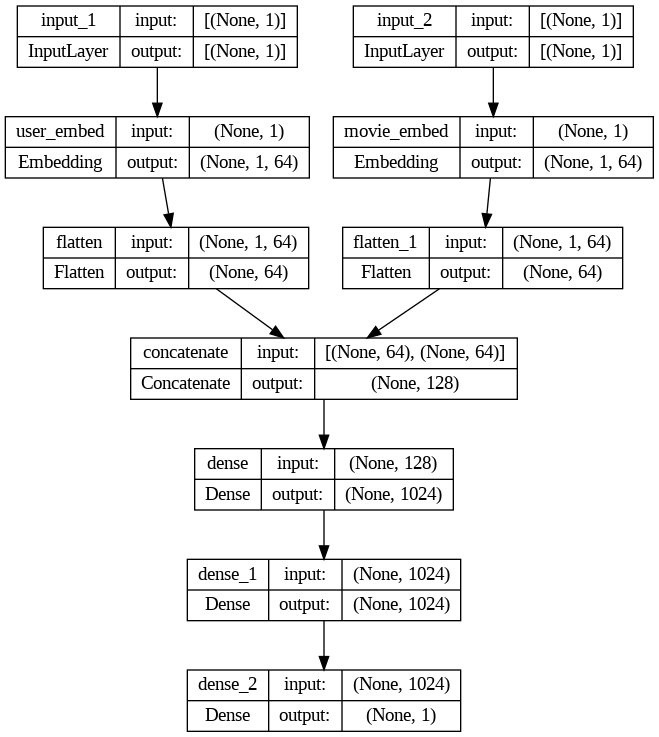

In [ ]:
utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = [EarlyStopping(patience=1)]

model.fit([train_user_ids, train_movie_ids], train_ratings,\
          validation_data=([val_user_ids, val_movie_ids], val_ratings),\
          epochs=10, batch_size=2048, callbacks=callbacks)

predictions2 = model.predict([val_user_ids, val_movie_ids])

Epoch 1/10
5880/5880 [==============================] - 98s 15ms/step - loss: 1.1613 - val_loss: 1.1064
Epoch 2/10
5880/5880 [==============================] - 52s 9ms/step - loss: 1.0899 - val_loss: 1.0787
Epoch 3/10
5880/5880 [==============================] - 51s 9ms/step - loss: 1.0574 - val_loss: 1.0579
Epoch 4/10
5880/5880 [==============================] - 50s 9ms/step - loss: 1.0326 - val_loss: 1.0457
Epoch 5/10
5880/5880 [==============================] - 49s 8ms/step - loss: 1.0114 - val_loss: 1.0428
Epoch 6/10
5880/5880 [==============================] - 49s 8ms/step - loss: 0.9915 - val_loss: 1.0401
Epoch 7/10
94076/94076 [==============================] - 159s 2ms/step


In [ ]:
nn_ratings2 = predictions2.flatten()

In [ ]:
rating_df2['nnRating2'] = nn_ratings2
rating_df2['nnError2'] = np.abs(rating_df2['rating'] - rating_df2['nnRating2'])
rating_df2

,userId,movieId,rating,avgRating,ratingError,nnRating,nnError,nnRating2,nnError2
0,0,1,3,8.141070,5.141070,8.130511,5.130511,8.240499,5.240499
1,0,11,10,8.702269,1.297731,8.706836,1.293164,7.791692,2.208308
2,0,20,8,8.257428,0.257428,8.235668,0.235668,7.707221,0.292779
3,0,30,6,8.713479,2.713479,8.578824,2.578824,8.358853,2.358853
4,0,36,7,6.873326,0.126674,6.855263,0.144737,5.796094,1.203906
...,...,...,...,...,...,...,...,...,...
3010420,21223,17960,8,6.103448,1.896552,6.330541,1.669459,7.265658,0.734342
3010421,21223,18777,7,7.117647,0.117647,7.700462,0.700462,8.042128,1.042128
3010422,21223,19061,4,4.863636,0.863636,4.881828,0.881828,4.276317,0.276317
3010423,21223,19780,8,7.586957,0.413043,7.873007,0.126993,8.547077,0.547077


In [ ]:
avg_user_rating_error3 = rating_df2.groupby('userId')['nnError2'].mean()
avg_user_rating_error3

userId
0        1.505170
1        1.906497
2        0.871853
3        1.031144
4        0.734813
           ...   
21219    1.016757
21220    1.250653
21221    1.231426
21222    1.453564
21223    1.058583
Name: nnError2, Length: 21224, dtype: float32

In [ ]:
mean_error3 = avg_user_rating_error3.mean()
mean_error3

1.0555829

In [ ]:
(np.abs(avg_user_rating_error3 - mean_error3)).mean()

0.2093486

In [ ]:
avg_user_rating_error3[me]

1.6097449

In [ ]:
# plot

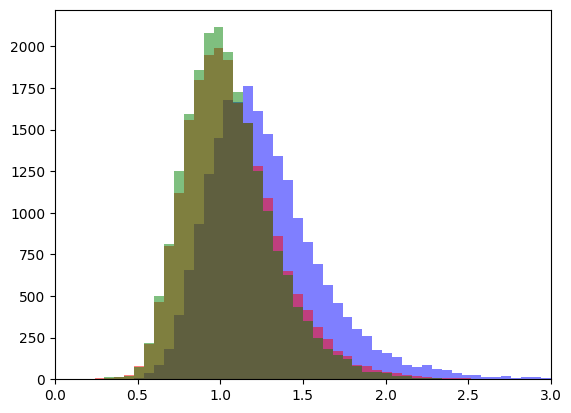

In [ ]:
plt.xlim(0, 3)
plt.hist(avg_user_rating_error, bins=50, range=(0, 3), color='blue', alpha=0.5)
plt.hist(avg_user_rating_error2, bins=50, range=(0, 3), color='red', alpha=0.5)
plt.hist(avg_user_rating_error3, bins=50, range=(0, 3), color='green', alpha=0.5)
plt.show()

In [ ]:
# nn_res save

In [ ]:
all_me = np.full(num_movies, me)
all_films = np.arange(num_movies)
all_my_ratings = model.predict([all_me, all_films]).flatten()
nn_ratings_my2 = [{'iid': int(iid), 'est': float(est)} for iid, est in enumerate(all_my_ratings)]


658/658 [==============================] - 1s 2ms/step


In [ ]:
with open('nn_res.json', 'w') as f:
    json.dump(nn_ratings_my2, f, indent=4)

In [ ]:
# svd_res and nn_res diff

In [ ]:
est_my1 = [pred['est'] for pred in nn_ratings_my]
est_my2 = [pred['est'] for pred in nn_ratings_my2]

# Calculate the absolute differences
diffs = [abs(a - b) for a, b in zip(est_my1, est_my2)]

# Calculate the average absolute error
avg_abs_error = sum(diffs) / len(diffs)

print(avg_abs_error)

0.7170306139803175
